# Load the speeds ups
Dictionary structure to store the speed
```json
driver_to_trip_to_speedups = {
    "driver1":  {
        "trip1": [
            speedup0 (pd.DataFrame),
            speedup1 (pd.DataFrame),
            ...
        ]

    }
}
```

In [3]:
import subprocess
import os, sys, pathlib

def root_path():
    result = subprocess.run(['git', 'rev-parse', '--show-toplevel'], stdout=subprocess.PIPE)
    path = result.stdout.decode("utf-8") 
    path = path.replace("\n", "")
    path = path.replace('/', '\\')
    return path

def temp_path() -> str:
    """Return the path to the temp folder of the git project"""
    return os.path.join(root_path(), "_temp")


In [4]:
from collections import defaultdict
import os, sys
import pandas as pd

def from_tripname_get_driver(database_speedup_parameters_analysis, trip_name):
    """Return the driver id of the trip"""
    row = database_speedup_parameters_analysis.loc[
        database_speedup_parameters_analysis["trip_name"] == trip_name
    ]
    if row.empty:
        return None
    return row["driver_id"].iloc[0]

def load_speedup() -> dict:
    windows_data_folder_path = os.path.join(root_path(), "_temp", "preprocessing", "extraction", "window_data")
    database_path = str(os.path.join(root_path(), "_temp", "speedup_parameters_and_properties.csv"))
    database_speedup_parameters_analysis: pd.DataFrame = pd.read_csv(database_path)
    driver_to_trips = defaultdict(dict)
    for i, trip_directory in enumerate(os.listdir(windows_data_folder_path)):
        speedup_list = []
        for window_file_name in os.listdir(os.path.join(windows_data_folder_path, trip_directory)):
            if "speed_up" in window_file_name:
                data_path = str(os.path.join(windows_data_folder_path, trip_directory, window_file_name))
                speed_up_df = pd.read_csv(data_path)
                speedup_list.append(speed_up_df)
        driver = from_tripname_get_driver(database_speedup_parameters_analysis, trip_directory)
        driver_to_trips[driver][trip_directory] = speedup_list
    return driver_to_trips
                
driver_to_trip_to_speedups = load_speedup()

# Compute

## Curvature

### Definitions

In [5]:
def normalize(value, max_value, min_value):
        return (value - min_value) / max_value

def compute_speedup_curvature(df):
    if df.empty:
        raise ValueError("dataframe empty")

    data = df
    peak_instant_index = data["LongitudinalVelocity_0x344_20"].idxmax()
    peak_velocity = data["LongitudinalVelocity_0x344_20"].iloc[peak_instant_index]
    start_velocity = data["LongitudinalVelocity_0x344_20"].iloc[0]
    n_samples = peak_instant_index + 1
    
    straight_line_from_start_to_peak = np.linspace(start=start_velocity, stop=peak_velocity, num=n_samples)
    velocity_sequence_from_start_to_peak = data["LongitudinalVelocity_0x344_20"][0:n_samples]
    diff_sum = 0
    
    max_velo = peak_velocity
    min_velo = start_velocity
    
    for straight_line_velo, real_velo in zip(straight_line_from_start_to_peak, velocity_sequence_from_start_to_peak):
        diff_sum += normalize(real_velo, max_velo, min_velo) - normalize(straight_line_velo, max_velo, min_velo)
    integral = diff_sum / n_samples
        
    return integral

def class_curvature(curvature: float) -> str:
    # is curvature flat
    flatness_tolerance = 0.15
    if abs(curvature) < flatness_tolerance:
        return "flat"
    # if not float positive or negative
    elif curvature < 0.0:
        return "summit_down"
    else:
        return "summit_up"

### Visualize tools

In [6]:
def plot_speedup_curvature(df: pd.DataFrame, speedup_name: str, ax) -> None:
    peak_instant_index = df["LongitudinalVelocity_0x344_20"].idxmax()
    peak_velocity = df["LongitudinalVelocity_0x344_20"].iloc[peak_instant_index]
    start_velocity = df["LongitudinalVelocity_0x344_20"].iloc[0]
    max_velocity = peak_velocity
    min_velocity =  start_velocity
    
    time = df["ts_s_0"]
    normalized_velocities = df["LongitudinalVelocity_0x344_20"].apply(lambda x: normalize(x, max_velocity, min_velocity))
    # Plot series in blue
    line, = ax.plot(time, normalized_velocities, color="blue")
    line.set_label("Actual data velocity")
    # Plot straight line in red
    n_samples = peak_instant_index + 1
    normalized_straight_line_from_start_to_peak = np.linspace(start=normalize(start_velocity, max_velocity, min_velocity), stop=normalize(peak_velocity, max_velocity, min_velocity), num=n_samples)
    line, = ax.plot(time[:n_samples], normalized_straight_line_from_start_to_peak, color="red")
    line.set_label("Straight line from start to peak velocity")
    curvature = compute_speedup_curvature(df)
    rounded_curvature = "{:.3f}".format(curvature)
    title = f"Speedup: {speedup_name}, curvature_area: {rounded_curvature} ({class_curvature(curvature)})"
    ax.set_title(title)
    # Fill the integral area
    color = "blue"
    if curvature > 0.0:
        color = "red"
    else:
        color = "green"
    ax.fill_between(x=time[:n_samples], y1=normalized_velocities[:n_samples], y2=normalized_straight_line_from_start_to_peak, color=color, alpha=0.2)

### Curvatures distribution among speedups

In [7]:
# Compute curvature for each speed ups
import numpy as np
rows = []
for driver, trip_to_speedups in driver_to_trip_to_speedups.items():
    curvatures = []
    for trip_name, speedups in trip_to_speedups.items():
        for i_su, speedup_df in enumerate(speedups):
            curvature = compute_speedup_curvature(speedup_df)
            rows.append(
                {
                    "driver": driver,
                    "speedup_name": f"{trip_name}-{i_su}",
                    "speedup": speedup_df,
                    "curvature": curvature
                }
            )
driver_to_speedup_curvature_df = pd.DataFrame(rows)

In [8]:
# Add curvature class
class_rows = []
for i, row in enumerate(rows):
    curvature = row["curvature"]
    curvature_class = class_curvature(curvature)
    class_rows.append(
        {
            "driver": row["driver"],
            "speedup_name": row["speedup_name"],
            "speedup": row["speedup"],
            "curvature": curvature,
            "curvature_class": curvature_class
        }
    )
driver_to_speedup_curvature_class_df = pd.DataFrame(class_rows)

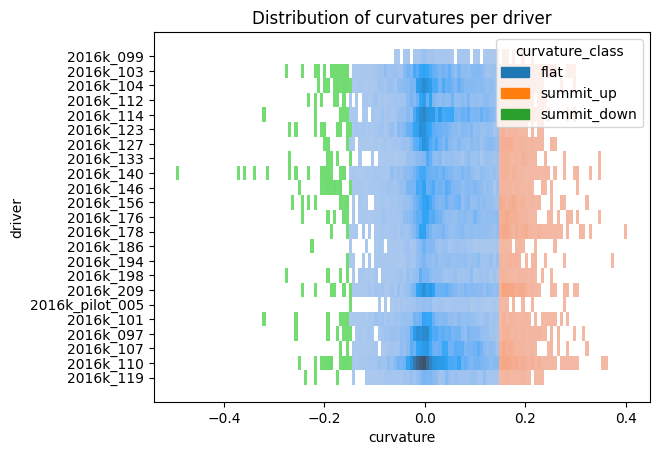

In [9]:
# Display
import matplotlib.pyplot as plt
import seaborn as sns
image_folder_path = f"C:\git\kdp_hlb_evalframework\_temp\img_generated_by_jupyter"
def img_path(filename: str) -> str:
    return f"{image_folder_path}{filename}.png"
fig = plt.figure()
ax = sns.histplot(data=driver_to_speedup_curvature_class_df, y="driver", x="curvature", hue="curvature_class")
# display value next to the bar
for i in ax.containers:
    ax.bar_label(i,)
title = "Distribution of curvatures per driver"
plt.title(title)
plt.show()
title.replace(" ", "_").lower()
fig.savefig(img_path(title))

In [16]:
from matplotlib.ticker import PercentFormatter
n_driver = len(driver_to_speedup_curvature_class_df["driver"])
fig, ax = plt.subplots(1, 1, figsize=(5, 1*n_driver))
sns.histplot(data=driver_to_speedup_curvature_class_df, y="driver", hue="curvature_class", multiple="fill", ax=ax)
for bars in ax.containers:
    widths = [b.get_width() for b in bars]
    labels = [f'{w * 100:.1f}%' if w > 0.001 else '' for w in widths]
    ax.bar_label(bars, labels=labels, label_type='center')
ax.yaxis.set_major_formatter(PercentFormatter(1))
plt.show()

ValueError: Image size of 500x2338700 pixels is too large. It must be less than 2^16 in each direction.

<Figure size 500x2.3387e+06 with 1 Axes>

### Curvatures per class for one driver
Comparison between real velocity and straight line

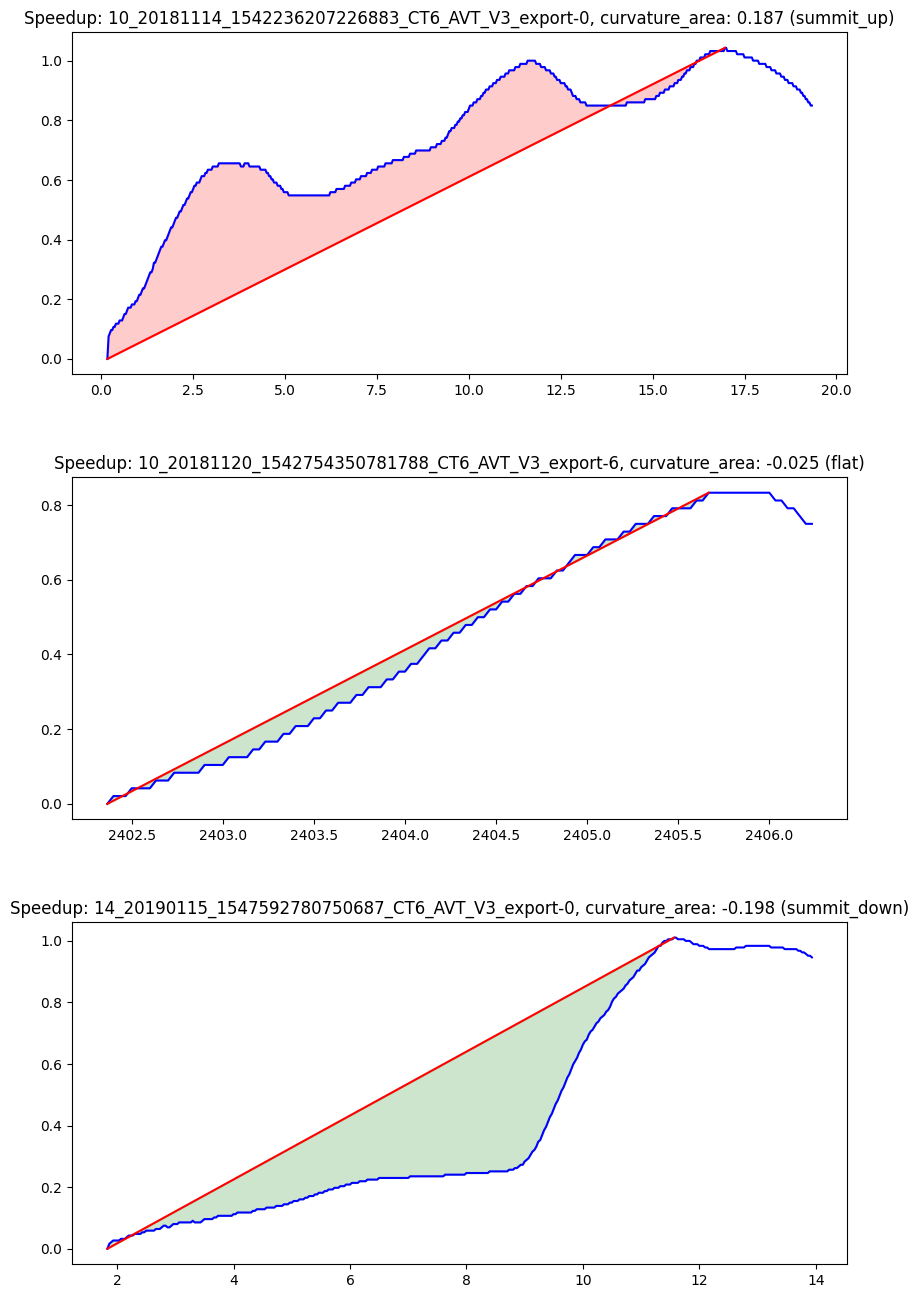

In [ ]:
import random
# Display curvatures for one driver
driver = "2016k_140"

def display_each_curvature_class_for_one_driver(curvatures_df: pd.DataFrame, driver_name: str) -> None:
    df_for_one_driver = curvatures_df[curvatures_df["driver"] == driver_name]
    curvature_classes_for_one_driver_df = pd.unique(df_for_one_driver["curvature_class"])
    n_class = len(curvature_classes_for_one_driver_df)
    fig, axs = plt.subplots(n_class, 1, figsize=(10,16))
    for i_class, curvature_class in enumerate(curvature_classes_for_one_driver_df):
        df_of_the_current_curvature_class = curvatures_df[curvatures_df["curvature_class"] == curvature_class]
        picked_row_index = random.randint(0, len(df_of_the_current_curvature_class))
        curvature_df = df_of_the_current_curvature_class.iloc[picked_row_index]
        plot_speedup_curvature(curvature_df["speedup"], curvature_df["speedup_name"], axs[i_class])
    fig.subplots_adjust(hspace=0.3)
    plt.show()
    title = f"One random speed curvature for each curvature class of the driver {driver_name}"
    title.replace(" ", "_").lower()
    fig.savefig(img_path(title))

display_each_curvature_class_for_one_driver(driver_to_speedup_curvature_class_df, driver)

### Statistics of curvatures per driver

#### Distribution of curvatures per driver

In [17]:
# Distribution of curvatures per drivers
## Add statistics
stat_rows = []
drivers =  pd.unique(driver_to_speedup_curvature_class_df["driver"])

fig, axs = plt.subplots(n_driver, 1, figsize=(10,3*n_driver), sharex="col")
for i, driver in enumerate(drivers):
    ax = axs[i]
    rows_for_one_driver = driver_to_speedup_curvature_class_df[driver_to_speedup_curvature_class_df["driver"] == driver]
    sns.histplot(rows_for_one_driver, x="curvature", ax=ax)
    n_row = len(rows_for_one_driver)
    title = f"Distribution of curvatures for driver: {driver} ({n_row} samples)"
    ax.set_title(title)
fig.subplots_adjust(hspace=0.3)
plt.show()
title = "Distribution of curvatures per driver"
title.replace(" ", "_").lower()
fig.savefig(img_path(title))

KeyboardInterrupt: 

Error in callback <function install_repl_displayhook.<locals>.post_execute at 0x0000015B1DCB91F8> (for post_execute):


ValueError: Image size of 1000x7016100 pixels is too large. It must be less than 2^16 in each direction.

ValueError: Image size of 1000x7016100 pixels is too large. It must be less than 2^16 in each direction.

<Figure size 1000x7.0161e+06 with 4068 Axes>

#### Averages curvatures per driver

Text(0.5, 1.0, 'Average curvatures for driver: 2016k_112 (1333 samples)')

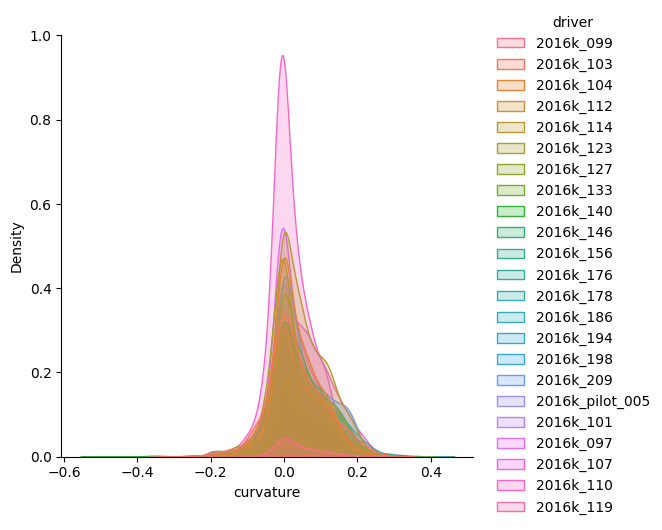

In [18]:
# average_curvature_rows = list()
# for i, driver in enumerate(drivers):
#     rows_for_one_driver = driver_to_speedup_curvature_class_df[driver_to_speedup_curvature_class_df["driver"] == driver]
#     curvature_mean = np.mean(rows_for_one_driver["curvature"])
#     average_curvature_rows.append(
#         {
#             "driver": driver,
#             "curvature_mean": curvature_mean
#         }
#     )
# driver_to_curvature_average = pd.DataFrame(average_curvature_rows)
sns.displot(driver_to_speedup_curvature_class_df, x="curvature", kind="kde", hue="driver", fill=True, common_norm=True)
# sns.histplot(driver_to_curvature_average, x="curvature_mean", ax=ax)
title = f"Average curvatures for driver: {driver} ({n_row} samples)"
ax.set_title(title)

c:\Users\LIJ3YH\.conda\envs\workingenv\lib\site-packages\seaborn\categorical.py:3025: UserWarning: catplot is a figure-level function and does not accept target axes. You may wish to try boxplot
  warnings.warn(msg, UserWarning)


ValueError: Image size of 7016100x400 pixels is too large. It must be less than 2^16 in each direction.

<Figure size 7.0161e+06x400 with 1 Axes>

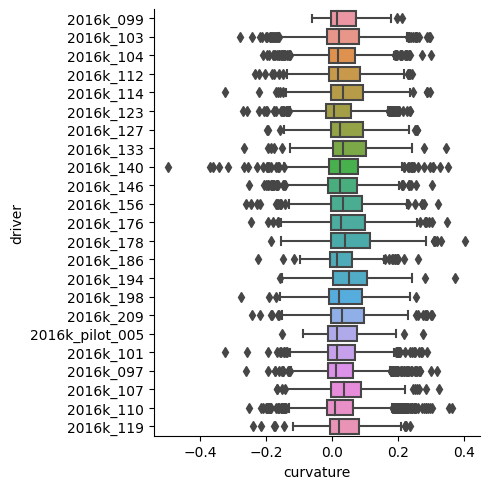

ValueError: Image size of 7016100x400 pixels is too large. It must be less than 2^16 in each direction.

In [19]:
# Display
fig, axs = plt.subplots(1, 1, figsize=(3*n_driver, 4))
# ax = sns.barplot(data=driver_to_speedup_curvature_class_df, y="driver", x="curvature", orient="h")
## display value next to the bar
ax = axs
sns.catplot(data=driver_to_speedup_curvature_class_df, y="driver", x="curvature", kind="box", ax=ax)
#ax.bar_label(ax.containers[0], fmt='%.3f')
title = "Average curvatures per driver"
ax.set_title(title)
plt.show()
title.replace(" ", "_").lower()
fig.savefig(img_path(title))

#### Average curvature rankings

In [20]:
# Compute curvature for each speed ups
speedup_curvatures = []
for driver, trip_to_speedups in driver_to_trip_to_speedups.items():
    curvatures = []
    for trip_name, speedups in trip_to_speedups.items():
        for i_su, speedup_df in enumerate(speedups):
            curvature = compute_speedup_curvature(speedup_df)
            speedup_curvatures.append(
                {
                    "driver_id": driver,
                    "speedup_name": f"{trip_name}-{i_su}",
                    "speedup": speedup_df,
                    "curvature": curvature
                }
            )
driver_to_speedup_curvature_df = pd.DataFrame(speedup_curvatures)

# Average of curvatures
driver_to_curvature_average = []
for driver in driver_to_speedup_curvature_df["driver_id"].unique():
    curvature_average = np.mean(driver_to_speedup_curvature_df[driver_to_speedup_curvature_df["driver_id"] == driver])
    driver_to_curvature_average.append([driver] + [curvature_average])
driver_to_curvature_average_df = pd.DataFrame(driver_to_curvature_average, columns=["driver_id", "curvature_avg"])

c:\Users\LIJ3YH\.conda\envs\workingenv\lib\site-packages\numpy\core\fromnumeric.py:3417: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
c:\Users\LIJ3YH\.conda\envs\workingenv\lib\site-packages\numpy\core\fromnumeric.py:3417: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
c:\Users\LIJ3YH\.conda\envs\workingenv\lib\site-packages\numpy\core\fromnumeric.py:3417: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before 

In [21]:
# Display sliders
sns.set_theme(style="whitegrid")
# Make the PairGrid
g = sns.PairGrid(driver_to_curvature_average_df.sort_values("curvature_avg", ascending=True),
                 x_vars=global_profile_summaries_df.columns[1:], y_vars=["driver_id"],
                 height=10, aspect=.25)
# Draw a dot plot using the stripplot function
g.map(sns.stripplot, size=10, orient="h", jitter=False,
      palette="flare_r", linewidth=1, edgecolor="w")

# # Use the same x axis limits on all columns and add better labels
# g.set(xlim=(0, 25), xlabel="Crashes", ylabel="")

# # Use semantically meaningful titles for the columns
titles = ["Global aggressiveness"]

for ax, title in zip(g.axes.flat, titles):

    # Set a different title for each axes
    ax.set(title=title)

    # Make the grid horizontal instead of vertical
    ax.xaxis.grid(False)
    ax.yaxis.grid(True)

sns.despine(left=True, bottom=True)

ValueError: Can only compare identically-labeled Series objects

# Analysis aggressiveness

## Manual groundtruth

In [ ]:
# Normalize the profile
min_curvature = min(driver_to_speedup_curvature_df["curvature"])
max_curvature = max(driver_to_speedup_curvature_df["curvature"])
driver_to_speedup_curvature_df["curvature"].apply(lambda x: (x + min_curvature) / max_curvature)
driver_curvature = driver_to_speedup_curvature_df[["driver_id", "curvature"]]
global_profile_summaries_df.to_csv("profiles_curvature.csv")